In [90]:
import gym
import numpy as np

class NormalizedActions(gym.ActionWrapper):
    ''' 将action范围重定在[0.1]之间
    '''
    def action(self, action):
        low_bound   = self.action_space.low
        upper_bound = self.action_space.high
        action = low_bound + (action + 1.0) * 0.5 * (upper_bound - low_bound)
        action = np.clip(action, low_bound, upper_bound)
        return action

    def reverse_action(self, action):
        low_bound   = self.action_space.low
        upper_bound = self.action_space.high
        action = 2 * (action - low_bound) / (upper_bound - low_bound) - 1
        action = np.clip(action, low_bound, upper_bound)
        return action

class OUNoise(object):
    '''Ornstein–Uhlenbeck噪声
    '''
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu # OU噪声的参数
        self.theta        = theta # OU噪声的参数
        self.sigma        = max_sigma # OU噪声的参数
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()
    def reset(self):
        self.obs = np.ones(self.action_dim) * self.mu
    def evolve_obs(self):
        x  = self.obs
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.obs = x + dx
        return self.obs
    def get_action(self, action, t=0):
        ou_obs = self.evolve_obs()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period) # sigma会逐渐衰减
        return np.clip(action + ou_obs, self.low, self.high) # 动作加上噪声后进行剪切

In [91]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity # 经验回放的容量
        self.buffer = [] # 缓冲区
        self.position = 0 
    
    def push(self, state, action, reward, next_state, done):
        ''' 缓冲区是一个队列，容量超出时去掉开始存入的转移(transition)
        '''
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity 
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size) # 随机采出小批量转移
        state, action, reward, next_state, done =  zip(*batch) # 解压成状态，动作等
        return state, action, reward, next_state, done
    
    def __len__(self):
        ''' 返回当前存储的量
        '''
        return len(self.buffer)

In [92]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim, init_w=3e-3):
        super(Actor, self).__init__()  
        self.linear1 = nn.Linear(state_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, action_dim)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, x):
#         print(f'actor netword, x: {x}')
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = torch.tanh(self.linear3(x))
        return x

In [93]:
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim, init_w=3e-3):
        super(Critic, self).__init__()
        
        self.linear1 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, 1)
        # 随机初始化为较小的值
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        # 按维数1拼接
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [94]:
class DDPG:
    def __init__(self, state_dim, action_dim, cfg):
        self.device = cfg.device
        self.critic = Critic(state_dim, action_dim, cfg.hidden_dim).to(cfg.device)
        self.actor = Actor(state_dim, action_dim, cfg.hidden_dim).to(cfg.device)
        self.target_critic = Critic(state_dim, action_dim, cfg.hidden_dim).to(cfg.device)
        self.target_actor = Actor(state_dim, action_dim, cfg.hidden_dim).to(cfg.device)

        # 复制参数到目标网络
        for target_param, param in zip(self.target_critic.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)
        for target_param, param in zip(self.target_actor.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data)

        self.critic_optimizer = optim.Adam(
            self.critic.parameters(),  lr=cfg.critic_lr)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=cfg.actor_lr)
        self.memory = ReplayBuffer(cfg.memory_capacity)
        self.batch_size = cfg.batch_size
        self.soft_tau = cfg.soft_tau # 软更新参数
        self.gamma = cfg.gamma
        
    def choose_action(self, state):
#         print(f'source state: {state}')
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)  # hoho: 为啥要unsqueeze一层？
        action = self.actor(state)
#         print(f'state: {state}, action: {action}')
        return action.detach().cpu().numpy()[0, 0]
    
    def update(self):
        if len(self.memory) < self.batch_size: # 当 memory 中不满足一个批量时，不更新策略
            return
        # 从经验回放中(replay memory)中随机采样一个批量的转移(transition)
        state, action, reward, next_state, done = self.memory.sample(self.batch_size)
        # 转变为张量
        state = torch.FloatTensor(state).to(self.device)
        next_state = torch.FloatTensor(next_state).to(self.device)
        action = torch.FloatTensor(action).to(self.device)
        reward = torch.FloatTensor(reward).unsqueeze(1).to(self.device)
        done = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(self.device)
        
#         print(f'state: {state}, action: {action}, reward: {reward}')
       
        policy_loss = self.critic(state, self.actor(state))
        policy_loss = -policy_loss.mean()
        next_action = self.target_actor(next_state)
        target_value = self.target_critic(next_state, next_action.detach())
        expected_value = reward + (1.0 - done) * self.gamma * target_value
        expected_value = torch.clamp(expected_value, -np.inf, np.inf)

        value = self.critic(state, action)  # 注意和上面self.critic(state, self.actor(state))的区别
        value_loss = nn.MSELoss()(value, expected_value.detach())
        
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()
        self.critic_optimizer.zero_grad()
        value_loss.backward()
        self.critic_optimizer.step()
        # 软更新
        for target_param, param in zip(self.target_critic.parameters(), self.critic.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - self.soft_tau) +
                param.data * self.soft_tau
            )
        for target_param, param in zip(self.target_actor.parameters(), self.actor.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - self.soft_tau) +
                param.data * self.soft_tau
            )

In [95]:
import sys
import os
curr_path = os.path.dirname(os.path.realpath('__file__'))  # 当前文件所在绝对路径
parent_path = os.path.dirname(curr_path)  # 父路径
sys.path.append(parent_path)  # 添加路径到系统路径

from DDPG.env import OUNoise

In [96]:
def train(cfg, env, agent):
    print('开始训练！')
    print(f'环境：{cfg.env_name}，算法：{cfg.algo_name}，设备：{cfg.device}')
    ou_noise = OUNoise(env.action_space)  # 动作噪声
    rewards = [] # 记录所有回合的奖励
    ma_rewards = []  # 记录所有回合的滑动平均奖励
    for i_ep in range(cfg.train_eps):
        state = env.reset()
        ou_noise.reset()
        done = False
        ep_reward = 0
        i_step = 0
        while not done:
            i_step += 1
            action = agent.choose_action(state)
            action = ou_noise.get_action(action, i_step) 
            next_state, reward, done, _ = env.step(action)
            ep_reward += reward
            agent.memory.push(state, action, reward, next_state, done)
            agent.update()
            state = next_state
        if (i_ep+1)%10 == 0:
            print('回合：{}/{}，奖励：{:.2f}'.format(i_ep+1, cfg.train_eps, ep_reward))
        rewards.append(ep_reward)
        if ma_rewards:
            ma_rewards.append(0.9*ma_rewards[-1]+0.1*ep_reward)
        else:
            ma_rewards.append(ep_reward)
    print('完成训练！')
    return rewards, ma_rewards

In [97]:
def test(cfg, env, agent):
    print('开始测试！')
    print(f'环境：{cfg.env_name}, 算法：{cfg.algo_name}, 设备：{cfg.device}')
    rewards = [] # 记录所有回合的奖励
    ma_rewards = []  # 记录所有回合的滑动平均奖励
    for i_ep in range(cfg.test_eps):
        state = env.reset() 
        done = False
        ep_reward = 0
        i_step = 0
        while not done:
            i_step += 1
            action = agent.choose_action(state)
            next_state, reward, done, _ = env.step(action)
            ep_reward += reward
            state = next_state
        print('回合：{}/{}, 奖励：{}'.format(i_ep+1, cfg.train_eps, ep_reward))
        rewards.append(ep_reward)
        if ma_rewards:
            ma_rewards.append(0.9*ma_rewards[-1]+0.1*ep_reward)
        else:
            ma_rewards.append(ep_reward)
        print(f"回合：{i_ep+1}/{cfg.test_eps}，奖励：{ep_reward:.1f}")
    print('完成测试！')
    return rewards, ma_rewards

In [98]:
import datetime
import gym
import torch


from common.utils import save_results,make_dir
from common.utils import plot_rewards

curr_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")  # 获取当前时间
algo_name = 'DDPG'  # 算法名称
env_name = 'Pendulum-v1'  # 环境名称，gym新版本（约0.21.0之后）中Pendulum-v0改为Pendulum-v1


In [99]:
class DDPGConfig:
    def __init__(self):
        self.algo_name = algo_name # 算法名称
        self.env_name = env_name # 环境名称
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 检测GPU
        self.train_eps = 300 # 训练的回合数
        self.test_eps = 50 # 测试的回合数
        self.gamma = 0.99 # 折扣因子
        self.critic_lr = 1e-3 # 评论家网络的学习率
        self.actor_lr = 1e-4 # 演员网络的学习率
        self.memory_capacity = 8000 # 经验回放的容量
        self.batch_size = 128 # mini-batch SGD中的批量大小
        self.target_update = 2 # 目标网络的更新频率
        self.hidden_dim = 256 # 网络隐藏层维度
        self.soft_tau = 1e-2 # 软更新参数
        self.save = False

In [100]:
def env_agent_config(cfg,seed=1):
    env = NormalizedActions(gym.make(cfg.env_name)) # 装饰action噪声
    env.seed(seed) # 随机种子
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    agent = DDPG(state_dim,action_dim,cfg)
    return env,agent

In [101]:
cfg = DDPGConfig()
env, agent = env_agent_config(cfg, seed=1)

In [102]:
rewards, ma_rewards = train(cfg, env, agent)

开始训练！
环境：Pendulum-v1，算法：DDPG，设备：cuda
回合：10/300，奖励：-776.41
回合：20/300，奖励：-255.07
回合：30/300，奖励：-369.67
回合：40/300，奖励：-243.67
回合：50/300，奖励：-471.58
回合：60/300，奖励：-380.23
回合：70/300，奖励：-254.34
回合：80/300，奖励：-626.01
回合：90/300，奖励：-690.30
回合：100/300，奖励：-535.20
回合：110/300，奖励：-255.36
回合：120/300，奖励：-513.77
回合：130/300，奖励：-489.72
回合：140/300，奖励：-490.86
回合：150/300，奖励：-613.38
回合：160/300，奖励：-838.62
回合：170/300，奖励：-737.51
回合：180/300，奖励：-258.37
回合：190/300，奖励：-250.16
回合：200/300，奖励：-636.67
回合：210/300，奖励：-854.54
回合：220/300，奖励：-492.76
回合：230/300，奖励：-828.14
回合：240/300，奖励：-753.94
回合：250/300，奖励：-763.63
回合：260/300，奖励：-645.28
回合：270/300，奖励：-692.36
回合：280/300，奖励：-629.45
回合：290/300，奖励：-765.99
回合：300/300，奖励：-634.80
完成训练！


D:\ProgramData\Anaconda3\envs\hoho_gym\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
D:\ProgramData\Anaconda3\envs\hoho_gym\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


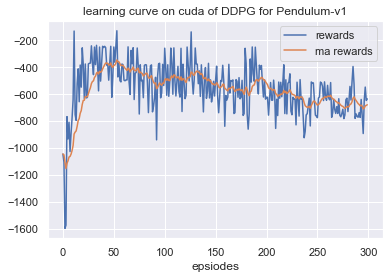

In [104]:
plot_rewards(rewards, ma_rewards, cfg, tag="train")  # 画出结果

In [106]:
rewards,ma_rewards = test(cfg,env,agent)

开始测试！
环境：Pendulum-v1, 算法：DDPG, 设备：cuda
回合：1/300, 奖励：-132.73326519507216
回合：1/50，奖励：-132.7
回合：2/300, 奖励：-134.727791004293
回合：2/50，奖励：-134.7
回合：3/300, 奖励：-132.92954398391458
回合：3/50，奖励：-132.9
回合：4/300, 奖励：-138.921321914889
回合：4/50，奖励：-138.9
回合：5/300, 奖励：-142.38406547853415
回合：5/50，奖励：-142.4
回合：6/300, 奖励：-145.1781397343196
回合：6/50，奖励：-145.2
回合：7/300, 奖励：-252.01757106433342
回合：7/50，奖励：-252.0
回合：8/300, 奖励：-248.3983679387513
回合：8/50，奖励：-248.4
回合：9/300, 奖励：-20.94229002536461
回合：9/50，奖励：-20.9
回合：10/300, 奖励：-249.62278557472015
回合：10/50，奖励：-249.6
回合：11/300, 奖励：-256.5768950438787
回合：11/50，奖励：-256.6
回合：12/300, 奖励：-334.9474580786559
回合：12/50，奖励：-334.9
回合：13/300, 奖励：-139.20796169132657
回合：13/50，奖励：-139.2
回合：14/300, 奖励：-133.1585803700883
回合：14/50，奖励：-133.2
回合：15/300, 奖励：-143.59914030369166
回合：15/50，奖励：-143.6
回合：16/300, 奖励：-135.21513574113095
回合：16/50，奖励：-135.2
回合：17/300, 奖励：-21.399951090662466
回合：17/50，奖励：-21.4
回合：18/300, 奖励：-145.1200442258965
回合：18/50，奖励：-145.1
回合：19/300, 奖励：-134.8689873902958
回合：19

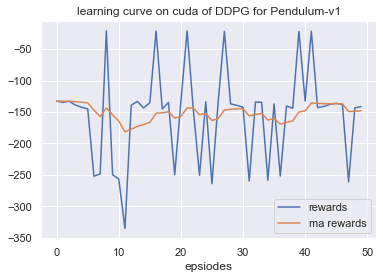

In [107]:
plot_rewards(rewards, ma_rewards, cfg, tag="test")  # 画出结果